# THCHS30 - 创建 Mel 频谱图

音频经过了以下变换：

1. 采样率与原始音频保持一致 `16000hz`
1. `win_length` 设置为 `100ms`，`hop_length` 设置为 `50ms`
1. Mel 频谱图 [filter-bank](https://librosa.org/doc/latest/generated/librosa.filters.mel.html) 选择 `80`
1. 将 Mel 频谱图转换成 [power spectrogram](https://librosa.org/doc/latest/generated/librosa.power_to_db.html)
1. 将取值范围调整到 `[0, 1]`

文本经过以下变换：

1. 拼音经过 [拼音字典](https://github.com/wu-jingtao/training-data/blob/master/speech_recognition/chinese/拼音字典/README.md) 转换成对应的数字索引

In [20]:
import os
import re
import json
import glob
import datetime
import random
import librosa
import librosa.display
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm

## 挂载 Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 解压数据

数据来自：[THCHS30数据下载.ipynb](https://github.com/wu-jingtao/training-data/blob/master/speech_recognition/chinese/THCHS30/notebooks/THCHS30数据下载.ipynb)

In [3]:
!tar zxvf /content/drive/Shareddrives/TeamDrive_top_edu/原始数据/THCHS30/data_thchs30.tgz > unzip_log.txt

In [4]:
!tar zxvf /content/drive/Shareddrives/TeamDrive_top_edu/原始数据/THCHS30/test-noise.tgz > unzip_noise_log.txt

## 加载拼音字典

In [ ]:
!wget https://raw.githubusercontent.com/wu-jingtao/training-data/master/speech_recognition/chinese/拼音字典/pinyin_mapper.json

In [ ]:
!wget https://raw.githubusercontent.com/wu-jingtao/training-data/master/speech_recognition/chinese/拼音字典/pinyin_mapper_without_intonation.json

In [7]:
with open('pinyin_mapper.json') as f:
  pinyin_mapper = json.load(f)

In [8]:
with open('pinyin_mapper_without_intonation.json') as f:
  pinyin_mapper_without_intonation = json.load(f)

## 文件列表

In [9]:
audio_list = glob.glob('/content/data_thchs30/data/*.wav')
noise_audio_list = glob.glob('/content/test-noise/0db/**/*.wav')

打乱列表

In [11]:
random.shuffle(audio_list)
random.shuffle(audio_list)
random.shuffle(noise_audio_list)
random.shuffle(noise_audio_list)

查看效果

In [14]:
noise_audio_list[:10]

['/content/test-noise/0db/car/D21_877.wav',
 '/content/test-noise/0db/white/D31_872.wav',
 '/content/test-noise/0db/cafe/D13_942.wav',
 '/content/test-noise/0db/car/D4_882.wav',
 '/content/test-noise/0db/white/D31_938.wav',
 '/content/test-noise/0db/car/D11_839.wav',
 '/content/test-noise/0db/car/D32_805.wav',
 '/content/test-noise/0db/cafe/D7_998.wav',
 '/content/test-noise/0db/car/D13_919.wav',
 '/content/test-noise/0db/white/D7_780.wav']

## 读取音频对应文本

In [15]:
audio_words = dict()
audio_pinyins = dict()

for path in audio_list:
  name = os.path.splitext(os.path.split(path)[1])[0]
  with open(path + '.trn') as f:
    words = next(f).strip()
    words = list(filter(lambda x: x != ' ', words))
    pinyins = next(f).strip().split(' ')
    audio_words[name] = words
    audio_pinyins[name] = pinyins

## 构建 [Mel](https://librosa.org/doc/latest/generated/librosa.feature.melspectrogram.html) 频谱图

In [16]:
def get_melspectrogram(file_list):
  def generator():
    for path in file_list:
      audio, sr = librosa.load(path, sr=None)
      S = librosa.feature.melspectrogram(audio, sr, n_fft=sr//10, hop_length=sr//20, n_mels=80)
      S_dB = librosa.power_to_db(S, ref=np.max) # 这里顺带做了音量统一
      S_dB = (S_dB + 80) / 80
      yield S_dB.T
  return generator

In [17]:
mel = tf.data.Dataset.from_generator(get_melspectrogram(audio_list), output_signature=tf.TensorSpec(shape=(None, 80), dtype=tf.float32))
noise_mel = tf.data.Dataset.from_generator(get_melspectrogram(noise_audio_list), output_signature=tf.TensorSpec(shape=(None, 80), dtype=tf.float32))

查看频谱图

数据形状 (173, 80)


[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

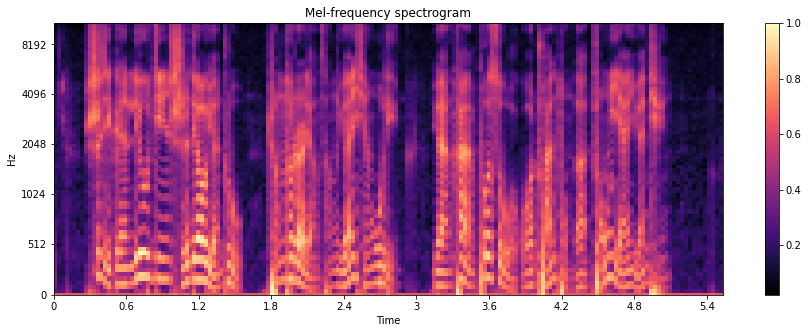

In [18]:
sample_data = next(mel.as_numpy_iterator())
print(f'数据形状 {sample_data.shape}')

fig, ax = plt.subplots(figsize=(15, 5))
img = librosa.display.specshow(sample_data.T, x_axis='time', y_axis='mel', sr=16000, ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='Mel-frequency spectrogram')

查看音频

In [ ]:
# 由于是使用 Griffin-Lim 算法复原的所以效果不太好，但这并不会影响到语音识别
sample_data = sample_data.T * 80 - 80
sample_data = librosa.db_to_power(sample_data)
sample_data = librosa.feature.inverse.mel_to_audio(sample_data, sr=16000, n_fft=16000//10, hop_length=16000//20)
ipd.Audio(sample_data, rate=16000)

## 构建文本

In [22]:
def get_words(file_list):
  def generator():
    for path in file_list:
      name = os.path.splitext(os.path.split(path)[1])[0]
      yield audio_words[name]
  return generator

In [23]:
words = tf.data.Dataset.from_generator(get_words(audio_list), output_signature=tf.TensorSpec(shape=(None,), dtype=tf.string))
noise_words = tf.data.Dataset.from_generator(get_words(noise_audio_list), output_signature=tf.TensorSpec(shape=(None,), dtype=tf.string))

查看效果

In [24]:
' '.join(map(lambda x: str(x, 'utf-8'), next(words.as_numpy_iterator())))

'十 几 根 鎏 金 石 雕 圆 柱 承 托 着 两 层 圆 形 屋 顶 远 看 颇 似 我 国 传 统 的 重 檐 圆 亭'

## 构建拼音

In [25]:
def get_pinyins(file_list):
  def generator():
    for path in file_list:
      name = os.path.splitext(os.path.split(path)[1])[0]
      yield audio_pinyins[name]
  return generator

In [26]:
pinyins = tf.data.Dataset.from_generator(get_pinyins(audio_list), output_signature=tf.TensorSpec(shape=(None,), dtype=tf.string))
noise_pinyins = tf.data.Dataset.from_generator(get_pinyins(noise_audio_list), output_signature=tf.TensorSpec(shape=(None,), dtype=tf.string))

查看效果

In [27]:
' '.join(map(lambda x: str(x, 'utf-8'), next(pinyins.as_numpy_iterator())))

'shi2 ji3 gen1 liu2 jin1 shi2 diao1 yuan2 zhu4 cheng2 tuo1 zhe5 liang3 ceng2 yuan2 xing2 wu1 ding3 yuan3 kan4 po1 si4 wo3 guo2 chuan2 tong3 de5 zhong4 yan2 yuan2 ting2'

## 构建有声调拼音索引

In [29]:
def get_pinyin_index(file_list):
  def generator():
    regex = re.compile('^([a-z]+)(\d?)$')
    for path in file_list:
      name = os.path.splitext(os.path.split(path)[1])[0]
      pinyins = audio_pinyins[name]
      result = np.empty(shape=len(pinyins), dtype=np.int32)
      for i, pinyin in enumerate(pinyins):
        yin, diao = regex.match(pinyin).groups()
        if diao != '' and diao in '1234':
          result[i] = pinyin_mapper[pinyin]
        else:
          # 将第5声轻音归为1声
          result[i] = pinyin_mapper[yin + '1']
      yield result
  return generator

In [30]:
pinyin_index = tf.data.Dataset.from_generator(get_pinyin_index(audio_list), output_signature=tf.TensorSpec(shape=(None,), dtype=tf.int32))
noise_pinyin_index = tf.data.Dataset.from_generator(get_pinyin_index(noise_audio_list), output_signature=tf.TensorSpec(shape=(None,), dtype=tf.int32))

查看效果

In [31]:
sample_data = next(pinyin_index.as_numpy_iterator())
sample_data = list(map(lambda x: str(x), sample_data))
print(' '.join(sample_data))
print(' '.join(map(lambda x: pinyin_mapper[x], sample_data)))

1197 526 400 717 548 1197 272 1485 1583 145 1340 1552 698 113 1485 1409 1376 282 1486 591 1004 1239 1374 445 173 1318 244 1575 1441 1485 1313
shi2 ji3 gen1 liu2 jin1 shi2 diao1 yuan2 zhu4 cheng2 tuo1 zhe1 liang3 ceng2 yuan2 xing2 wu1 ding3 yuan3 kan4 po1 si4 wo3 guo2 chuan2 tong3 de1 zhong4 yan2 yuan2 ting2


## 构建无声调拼音索引

In [32]:
def get_pinyin_index_without_intonation(file_list):
  def generator():
    regex = re.compile('^([a-z]+)\d?$')
    for path in file_list:
      name = os.path.splitext(os.path.split(path)[1])[0]
      pinyins = audio_pinyins[name]
      result = np.empty(shape=len(pinyins), dtype=np.int32)
      for i, pinyin in enumerate(pinyins):
        yin = regex.match(pinyin).group(1)
        result[i] = pinyin_mapper_without_intonation[yin]
      yield result
  return generator

In [33]:
pinyin_index_without_intonation = tf.data.Dataset.from_generator(get_pinyin_index_without_intonation(audio_list), output_signature=tf.TensorSpec(shape=(None,), dtype=tf.int32))
noise_pinyin_index_without_intonation = tf.data.Dataset.from_generator(get_pinyin_index_without_intonation(noise_audio_list), output_signature=tf.TensorSpec(shape=(None,), dtype=tf.int32))

查看效果

In [34]:
sample_data = next(pinyin_index_without_intonation.as_numpy_iterator())
sample_data = list(map(lambda x: str(x), sample_data))
print(' '.join(sample_data))
print(' '.join(map(lambda x: pinyin_mapper_without_intonation[x], sample_data)))

299 131 100 179 137 299 68 371 395 36 335 388 174 28 371 352 344 70 371 147 251 309 343 111 43 329 61 393 360 371 328
shi ji gen liu jin shi diao yuan zhu cheng tuo zhe liang ceng yuan xing wu ding yuan kan po si wo guo chuan tong de zhong yan yuan ting


## 创建缓存数据

无噪音数据

In [35]:
!mkdir THCHS30_mel

In [36]:
mel_cache = mel.cache('THCHS30_mel/audios')
words_cache = words.cache('THCHS30_mel/words')
pinyins_cache = pinyins.cache('THCHS30_mel/pinyins')
pinyin_index_cache = pinyin_index.cache('THCHS30_mel/pinyin_index')
pinyin_index_without_intonation_cache = pinyin_index_without_intonation.cache('THCHS30_mel/pinyin_index_without_intonation')

In [40]:
with tqdm(total=len(audio_list), desc='mel_cache') as pbar:
  for i in mel_cache: pbar.update()

with tqdm(total=len(audio_list), desc='words_cache') as pbar:
  for i in words_cache: pbar.update()

with tqdm(total=len(audio_list), desc='pinyins_cache') as pbar:
  for i in pinyins_cache: pbar.update()

with tqdm(total=len(audio_list), desc='pinyin_index_cache') as pbar:
  for i in pinyin_index_cache: pbar.update()

with tqdm(total=len(audio_list), desc='pinyin_index_without_intonation_cache') as pbar:
  for i in pinyin_index_without_intonation_cache: pbar.update()

pinyin_index_without_intonation_cache: 100%|██████████| 13388/13388 [00:06<00:00, 2191.75it/s]


有噪音数据

In [37]:
!mkdir THCHS30_mel_noise

In [38]:
noise_mel_cache = noise_mel.cache('THCHS30_mel_noise/audios')
noise_words_cache = noise_words.cache('THCHS30_mel_noise/words')
noise_pinyins_cache = noise_pinyins.cache('THCHS30_mel_noise/pinyins')
noise_pinyin_index_cache = noise_pinyin_index.cache('THCHS30_mel_noise/pinyin_index')
noise_pinyin_index_without_intonation_cache = noise_pinyin_index_without_intonation.cache('THCHS30_mel_noise/pinyin_index_without_intonation')

In [41]:
with tqdm(total=len(noise_audio_list), desc='noise_mel_cache') as pbar:
  for i in noise_mel_cache: pbar.update()

with tqdm(total=len(noise_audio_list), desc='noise_words_cache') as pbar:
  for i in noise_words_cache: pbar.update()

with tqdm(total=len(noise_audio_list), desc='noise_pinyins_cache') as pbar:
  for i in noise_pinyins_cache: pbar.update()

with tqdm(total=len(noise_audio_list), desc='noise_pinyin_index_cache') as pbar:
  for i in noise_pinyin_index_cache: pbar.update()

with tqdm(total=len(noise_audio_list), desc='noise_pinyin_index_without_intonation_cache') as pbar:
  for i in noise_pinyin_index_without_intonation_cache: pbar.update()

noise_pinyin_index_without_intonation_cache: 100%|██████████| 7485/7485 [00:03<00:00, 2188.94it/s]


## 创建说明文件

In [42]:
readme = '''数据来源：http://www.openslr.org/18/
项目地址：https://github.com/wu-jingtao/training-data/blob/master/speech_recognition/chinese/README.md
创建时间：{}

数据类型：
audios：音频对应的 mel 频谱图
  {}

words：音频对应的文字
  {}

pinyins：音频对应的拼音
  {}

pinyin_index：音频对应的带声调拼音索引
  {}

pinyin_index_without_intonation：音频对应的不带声调拼音索引
  {}

示例代码：
>>> data = tf.data.Dataset.from_generator(lambda: None, output_signature=tf.TensorSpec(shape=(None, 80), dtype=tf.float32))
>>> data = data.cache('文件夹路径/audio')
'''

readme = readme.format(
      datetime.datetime.today(),
      mel_cache.element_spec,
      words_cache.element_spec,
      pinyins_cache.element_spec,
      pinyin_index_cache.element_spec,
      pinyin_index_without_intonation_cache.element_spec
    )

with open('THCHS30_mel/README.txt', 'w') as f:
  f.write(readme)

with open('THCHS30_mel_noise/README.txt', 'w') as f:
  f.write(readme)

## 压缩文件

In [43]:
!7z a THCHS30_mel.7z THCHS30_mel > zip_log.txt

In [44]:
!7z a THCHS30_mel_noise.7z THCHS30_mel_noise > zip_noise_log.txt

## 保存到 Google Drive

In [45]:
!cp THCHS30_mel.7z /content/drive/Shareddrives/TeamDrive_top_edu/生成数据/THCHS30_mel.7z

In [46]:
!cp THCHS30_mel_noise.7z /content/drive/Shareddrives/TeamDrive_top_edu/生成数据/THCHS30_mel_noise.7z

In [47]:
!cp -r THCHS30_mel /content/drive/Shareddrives/TeamDrive_top_edu/生成数据/

In [48]:
!cp -r THCHS30_mel_noise /content/drive/Shareddrives/TeamDrive_top_edu/生成数据/